In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

%matplotlib inline
def show(img):   
    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('dark_background')


In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0],True)
#     except RuntimeError as e:
#         print(e)
    

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [4]:
from tensorflow.compat.v1 import ConfigProto,InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [5]:
import os
# tf.debugging.set_log_device_placement(True)
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(os.popen('nvidia-smi').read())

print(c)


Mon Aug  3 17:18:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   54C    P0   126W / 300W |  10516MiB / 32480MiB |     92%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   43C    P0    55W / 300W |   1001MiB / 32480MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
        

In [ ]:
# tf.keras.applications.ResNet101

In [14]:
# df, img 불러오고 model화 시키기 전 전처리과정
img_size = 224
model_weight = "resnet101_roi.h5"

df_path = ".."
img_path = "20200728_Carpal Bone ROI_filter"


df = pd.read_excel(df_path+"/BA_Total.xlsx")
l = len(df)

file_name = np.array(["{0:03d}_05_02.jpg".format(i+1) for i in range(l)])

df['boneage'] = df.BA*12
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()
df["BA_z"] = (df.boneage-ba_mean)/ba_std
df.filename = file_name
df["gender"] = df["성별"]%2

from sklearn.model_selection import train_test_split



In [15]:
df = df.drop(218)
df = df.reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

In [11]:
def multi_generator(df):
    gender_in = np.array(df.gender)
    img_in = []
    age = np.array(df.BA_z)
    
    for file_path in df.filename:
        img = cv2.imread(img_path+'/'+file_path)
        small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
        img_in.append(small)
        
    img_in = np.array(img_in)
        
    
    return [gender_in,img_in],age

In [12]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

In [13]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
# tf.keras.applications.resnet50.ResNet50

In [16]:
img_size = 224
g_input = Input(shape = (1,))
g_output = Dense(64,activation = 'relu')(g_input)

g_model = Model(inputs = g_input,outputs = g_output)

model_1 = tf.keras.applications.resnet.ResNet101(input_shape = (img_size, img_size, 3),
                                               include_top = False,
                                               weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(2048, activation = 'relu'))



con = concatenate([g_model.output, model_2.output])
dense1 = Dense(1024,activation='relu')(con)
# batch = BatchNormalization()(dense1)
# drop = Dropout(0.5)(dense1)
dense2 = Dense(512,activation='relu')(dense1)
# dense3 = Dense(10,activation='softmax')(dense2)
model_out = Dense(1,activation = "linear")(dense2)

model = Model([g_input,model_2.input],model_out)
model.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

171450368/171446536 [==============================] - 9s 0us/step


In [18]:
model_1.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [19]:
train_X,train_y = multi_generator(train_df)
val_X, val_y = multi_generator(val_df)

Mon Aug  3 11:44:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   34C    P0    55W / 300W |   1019MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   37C    P0    53W / 300W |   9069MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

Epoch 1/100
10/10 [==============================] - 8s 785ms/step - loss: 5973.0483 - mae_in_months: 533.7286 - val_loss: 513100.1562 - val_mae_in_months: 9858.4336 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 2s 186ms/step - loss: 3.1347 - mae_in_months: 22.6840 - val_loss: 70711024.0000 - val_mae_in_months: 144712.0938 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 5s 544ms/step - loss: 1.7419 - mae_in_months: 18.5831 - val_loss: 373819.0312 - val_mae_in_months: 10575.3525 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 5s 527ms/step - loss: 0.8162 - mae_in_months: 12.5955 - val_loss: 14715.4902 - val_mae_in_months: 2011.8447 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 6s 593ms/step - loss: 1.0940 - mae_in_months: 15.3857 - val_loss: 551.4442 - val_mae_in_months: 379.3638 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 2s 189ms/step - loss: 0.5796 - mae_in_months: 10.7803 - val_loss: 14

Epoch 50/100
10/10 [==============================] - 2s 184ms/step - loss: 0.0118 - mae_in_months: 1.5392 - val_loss: 0.2055 - val_mae_in_months: 6.4112 - lr: 0.0010
Epoch 51/100
10/10 [==============================] - 6s 551ms/step - loss: 0.0135 - mae_in_months: 1.6691 - val_loss: 0.1823 - val_mae_in_months: 6.1740 - lr: 0.0010
Epoch 52/100
10/10 [==============================] - 2s 184ms/step - loss: 0.0115 - mae_in_months: 1.5328 - val_loss: 0.1903 - val_mae_in_months: 6.2534 - lr: 0.0010
Epoch 53/100
10/10 [==============================] - 2s 184ms/step - loss: 0.0160 - mae_in_months: 1.8364 - val_loss: 0.1858 - val_mae_in_months: 6.2098 - lr: 0.0010
Epoch 54/100
10/10 [==============================] - 2s 182ms/step - loss: 0.0213 - mae_in_months: 2.0655 - val_loss: 0.1992 - val_mae_in_months: 6.4016 - lr: 0.0010
Epoch 55/100
10/10 [==============================] - 2s 181ms/step - loss: 0.0106 - mae_in_months: 1.4352 - val_loss: 0.1829 - val_mae_in_months: 6.0679 - lr: 0.001

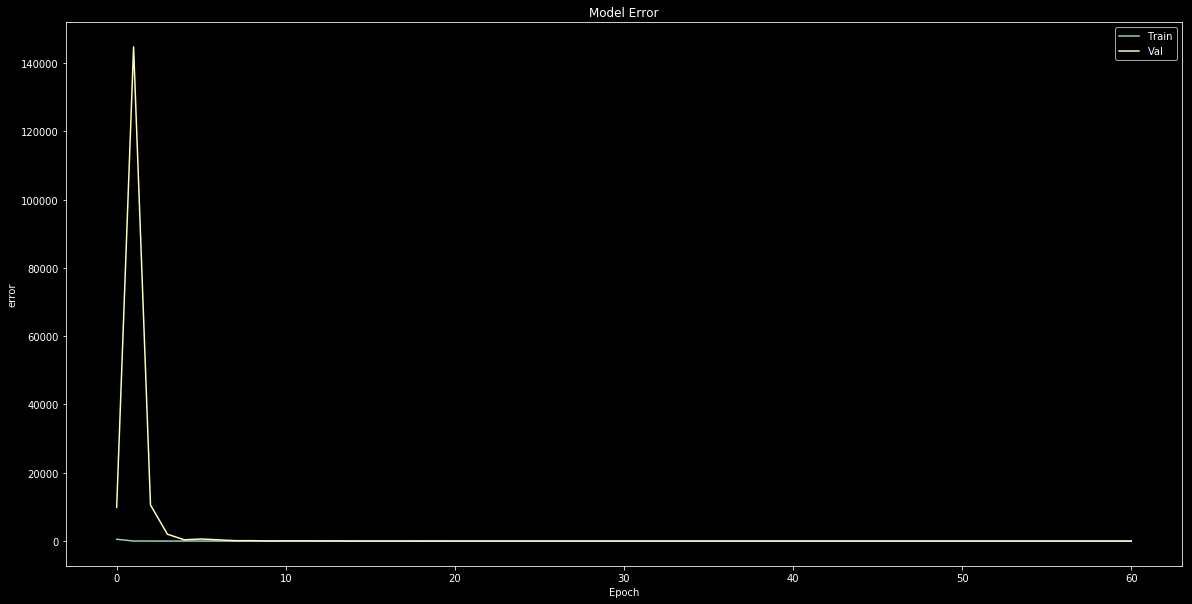

In [21]:
# 모델 fit

epochs = 100
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 10,
                              verbose=0, mode='auto')

mc = ModelCheckpoint(model_weight, monitor='val_loss', mode='min', save_best_only=True)
rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=10,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,mc,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)
plot_it(history)

In [22]:
print(os.popen('nvidia-smi').read())

Mon Aug  3 11:48:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   38C    P0    55W / 300W |   9069MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   51C    P0   176W / 300W |  17261MiB / 32480MiB |     86%      Default |
+-------------------------------+----------------------+----------------------+
        

In [23]:
model.load_weights(model_weight)

In [24]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
r2 = r2_score(val_df.boneage,pred)
print(f"mae_year : {mae/12}, mse : {mse/12},r2_score : {r2}" )

3/3 [==============================] - 0s 31ms/step - loss: 0.1823 - mae_in_months: 6.1740
mae_year : 0.5144990682601929, mse : 0.015188770989576975,r2_score : 0.798997123042773


In [25]:
result_df = pd.read_csv("result.csv")
result_df.loc[len(result_df)]=(model_weight,mae/12,mse/12,r2,True,False)
result_df.to_csv("result.csv",index=False)
result_df

,model,mae,mse,r2_score,roi,class
0,xception++,1.540548,17.096090,-180.695600,False,False
1,vgg-ba,1.160614,0.073136,-0.303073,False,False
2,vgg-ba,0.670392,0.025254,-0.570250,True,False
3,xception++,0.557815,0.016407,-0.361841,True,False
4,pre xception++,0.639215,0.022091,-1.055396,True,False
5,xception+gender,0.551765,0.017635,0.766628,True,False
6,pre-xception+gender,0.600951,0.020432,0.729614,True,False
7,tjnet-gender2,0.407535,0.009509,0.874158,True,False
8,tjnet_kaggle.h5,0.929146,0.011265,0.870070,True,False
9,resnet_roi.h5,0.564176,0.016662,0.779505,True,False
